In [1]:
import numpy as np
import pandas as pd
import matplotlib
import os
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from abc import ABCMeta, abstractmethod
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [2]:
def read_data(path):
    data = pd.read_csv(path)
    return data

In [3]:
path = os.path.realpath(os.path.join(os.getcwd() , '..', 'data_for_training', 'BEV_data_w_hpi.csv'))

In [4]:
data = read_data(path)
if "Unnamed: 0.1" in data.columns:
    data = data.drop(["Unnamed: 0.1"], axis = 1)

In [5]:
data.head()

,zip code,number_registration,Population,household count,"<10,000","10,000~14,999","15,000~24,999","25,000~34,999","35,000~49,999","50,000~74,999","75,000~99,999","100,000~149,999","150,000~199,999",">200,000",EV charging station number,housing_price_index
0,98575,1,142,73,13.7,0.0,8.2,12.3,12.3,19.2,15.1,12.3,2.7,4.1,2,290.76
1,98068,10,256,108,0.0,0.0,2.8,0.0,13.9,24.1,7.4,39.8,12.0,0.0,11,265.53
2,98814,6,376,217,2.3,26.7,4.6,14.3,12.4,23.5,6.0,10.1,0.0,0.0,0,239.77
3,98638,10,1225,493,4.3,5.1,8.9,15.0,13.8,21.9,14.4,10.5,2.2,3.9,0,172.13
4,98605,3,1165,417,5.0,5.3,15.3,8.9,12.7,24.0,13.9,13.4,1.4,0.0,2,366.78


In [6]:
y = data["number_registration"]
X = data.drop(['number_registration',"zip code" ], axis =1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=88)

In [7]:
print(X_train)

     Population  household count  <10,000  10,000~14,999  15,000~24,999  \
287       23413             7470      1.5            1.1            1.8   
387       41740            16294      7.1            5.1           10.9   
18         1195              398      9.8            0.0            0.0   
211       27550            10136      2.5            2.2            8.4   
352        7758             4299      8.3            5.7            7.0   
..          ...              ...      ...            ...            ...   
353       29666            11600      4.7            3.7            7.8   
62         2521             1010      6.3            5.0           11.9   
101        3119              919      2.5            2.8           10.0   
362        7683             3536      4.6            4.0            7.7   
288       22906             9133      3.4            3.5            7.2   

     25,000~34,999  35,000~49,999  50,000~74,999  75,000~99,999  \
287            1.9            3.

In [8]:
def OSR2(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
    return (1- SSE/SST)

### GradientBoostingRegressor

In [9]:
reg = GradientBoostingRegressor(random_state=88)
reg.fit(X_train, y_train)
print("OSR2: ",OSR2(reg, X_test, y_test, y_train))

OSR2:  0.9129423703112861


### Classification Tree 


In [10]:
bev_data = data.copy(deep=True)

In [18]:
bev_data['class'] = np.zeros(len(bev_data))
for i in range(len(bev_data)):
    if bev_data['number_registration'][i] < 50:
        bev_data['class'][i] = 'A'
    
    elif bev_data['number_registration'][i] < 200:
        bev_data['class'][i] = 'B'
    elif bev_data['number_registration'][i] < 400:
        bev_data['class'][i] = 'C'
    else:
        bev_data['class'][i] = 'D'

/var/folders/k9/8ly2zgmn2fqfns27djqldxth0000gn/T/ipykernel_69954/3867495291.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bev_data['class'][i] = 'A'


In [35]:
y = bev_data['class']
X = bev_data.drop(['class', 'zip code', 'number_registration'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 88)

In [40]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

dtc = DecisionTreeClassifier(class_weight = 'balanced',
                             min_samples_leaf= 3,
                             min_samples_split= 2,
                              random_state = 88)
cv = KFold(n_splits= 10, random_state= 88, shuffle = True)
grid_values = {'ccp_alpha': np.linspace(0,1,2001)}

dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=cv, verbose=0)


dtc_cv_acc = dtc_cv_acc.fit(X_train, y_train)

y_pred = dtc_cv_acc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
print('Precision:',precision_score(y_test, y_pred, average = 'weighted'))
print('Recall:',recall_score(y_test, y_pred, average = 'weighted'))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])

Confusion Matrix : 
 [[42  4  0  0]
 [10 22  7  1]
 [ 0  4 10  3]
 [ 0  0  2 16]]
Precision: 0.7424342802333234
Recall: 0.743801652892562


/var/folders/k9/8ly2zgmn2fqfns27djqldxth0000gn/T/ipykernel_69954/2264077292.py:26: RuntimeWarning: invalid value encountered in long_scalars
  TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])


In [41]:
# Accessing model best accuracy based on cross-validated results
model_acc = dtc_cv_acc.best_score_ # TODO: calculate CV CART accuracy
print(f'CART Best Accuracy: {model_acc:.4f}')

CART Best Accuracy: 0.7187


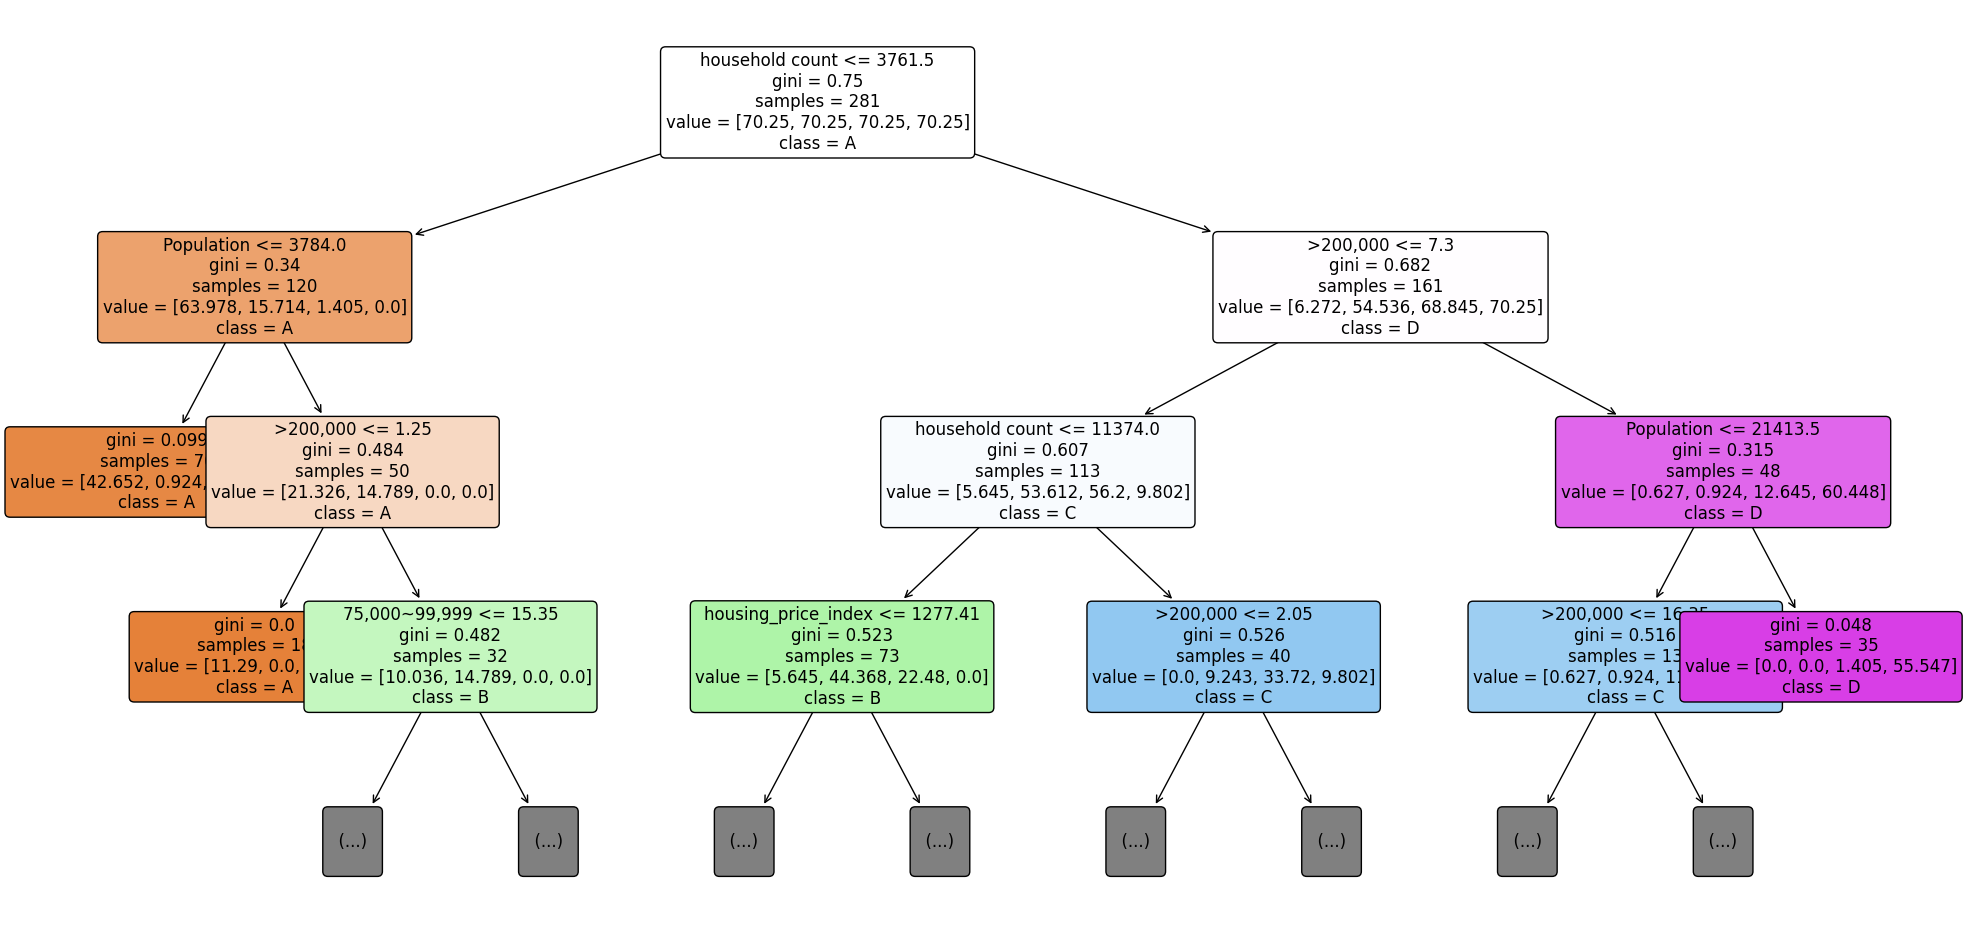

In [42]:

from sklearn.tree import plot_tree
plt.figure(figsize=(24,12))
plot_tree(dtc_cv_acc.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=['A','B','C','D'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12,
          max_depth=3)
plt.show()